Option B (train on a train split and calculate SHAP values on the test split) is generally preferred for the following reasons:

Generalizability: It ensures you're interpreting the model's predictions on unseen data, reflecting its real-world behavior.
Avoids Data Leakage: Prevents information from the test set influencing the training process, maintaining the integrity of the evaluation.

In [ ]:
# Mount google drive at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting seeds for reproducibility
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE
import pandas as pd
np.random.seed(42)

In [ ]:
data_file_path = "/content/drive/MyDrive/protein_props/features/protein_props.json"
druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/NEW_WORK/druggable_proteins.txt"
investigational_proteins_file_path = "/content/drive/MyDrive/protein_props/NEW_WORK/investigational_proteins.txt"

with open(data_file_path, 'r') as f:
    protein_data = json.load(f)

print("Total number of uniprot human verified proteins:", len(protein_data))

# Extracting list of druggable and approved druggable proteins
with open(druggable_proteins_file_path, 'r') as f:
    approved_druggable_proteins = f.read().splitlines()

with open(investigational_proteins_file_path, 'r') as f:
    investigational_proteins = f.read().splitlines()

druggable_proteins = approved_druggable_proteins + investigational_proteins

print("Number of druggable proteins:", len(druggable_proteins))
print("Number of druggable approved proteins:", len(approved_druggable_proteins))


# Fetching feature data for all proteins
properties = (pd.read_json("/content/drive/MyDrive/protein_props/features/protein_props.json")).transpose()
is_druggable = [1 if i in druggable_proteins else 0 for i in properties.index]
is_approved_druggable = [1 if i in approved_druggable_proteins else 0 for i in properties.index]

properties["is_druggable"] = is_druggable
properties["is_approved_druggable"] = is_approved_druggable

PCP_properties = properties.copy()
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_acid_percent = {i:[] for i in amino_acids}
for i in PCP_properties['Amino Acid Percent']:
  for aa in amino_acids:
    amino_acid_percent[aa].append(i[aa])
for aa in amino_acids:
  PCP_properties = pd.concat([PCP_properties, pd.Series(amino_acid_percent[aa], index = PCP_properties.index, name = f"Amino Acid Percent {aa}")], axis = 1)

PCP_properties[f"Molar Extinction Coefficient 1"] = pd.Series([x[0] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)
PCP_properties[f"Molar Extinction Coefficient 2"] = pd.Series([x[1] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)

PCP_properties[f"Secondary Structure helix"] = pd.Series([x[0] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure turn"] = pd.Series([x[1] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure sheet"] = pd.Series([x[2] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)

PCP_properties.drop(columns = ['Amino Acid Count','Amino Acid Percent',"Molar Extinction Coefficient","Flexibility","Secondary Structure",'Sequence'], inplace = True)
PCP_properties['Sequence Length'] = PCP_properties['Sequence Length'].astype(int)
PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']] = PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']].astype(float)

with open("/content/drive/MyDrive/protein_props/features/gdpc_encodings.json", 'r') as file:
    data = json.load(file)
gpdc_encodings = pd.DataFrame(data).transpose()

ppi = pd.read_json("/content/drive/MyDrive/protein_props/features/ppi.json").transpose()
ppi_network = pd.read_csv("/content/drive/MyDrive/protein_props/features/ppi_network_properties.csv")
ppi_network.index = ppi_network['Unnamed: 0']
ppi_network.drop(columns = ['Unnamed: 0'], inplace = True)
ppi = pd.concat([ppi, ppi_network], axis = 1)

glycolisation = pd.read_csv("/content/drive/MyDrive/protein_props/features/glycosylation.csv")
glycolisation.index = glycolisation['Unnamed: 0']
glycolisation.drop(columns = ['Unnamed: 0'], inplace = True)
ptm = pd.read_csv("/content/drive/MyDrive/protein_props/features/PTM_counts.csv")
ptm.index = ptm["Unnamed: 0"]
ptm.drop(columns = ['Unnamed: 0'], inplace = True)
ptm_counts = pd.concat([ptm, glycolisation], axis = 1)

with open("/content/drive/MyDrive/protein_props/features/subcellular_locations2.json", 'r') as file:
    data = json.load(file)
unique_groups = set()
for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry: unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

rows = []
for protein_id in PCP_properties.index:
    row = {group: 0 for group in unique_groups_list}
    if protein_id in data:
        for entry in data[protein_id].get("general", []):
            if "group" in entry and entry["group"] in unique_groups:
                row[entry["group"]] = 1
    row["protein_id"] = protein_id
    rows.append(row)

subcellular_data = pd.DataFrame(rows).set_index("protein_id")

domains = pd.read_csv("/content/drive/MyDrive/protein_props/features/data_top20_updated.csv")
domains.index = domains['Unnamed: 0']
domains.drop(columns = ['Unnamed: 0'], inplace = True)

flexibility = pd.read_csv("/content/drive/MyDrive/protein_props/features/flexibility_properties.csv")
flexibility.index = flexibility['Unnamed: 0']
flexibility.drop(columns = ['Unnamed: 0'], inplace = True)

latent_data = pd.read_csv("/content/drive/MyDrive/protein_props/features/latent_values.csv").transpose()
latent_data.columns = [f"Latent_Value_{i+1}" for i in latent_data.columns]
final_data = pd.concat([PCP_properties,gpdc_encodings, ptm_counts, ppi, subcellular_data, domains, flexibility, latent_data], axis = 1).dropna()
features_list = final_data.columns
features_list = features_list.drop(['is_druggable','is_approved_druggable'])
features_list = list(features_list)
print(features_list)
print(len(features_list))


Total number of uniprot human verified proteins: 20434
Number of druggable proteins: 2915
Number of druggable approved proteins: 2233
['Sequence Length', 'Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7', 'Amino Acid Percent A', 'Amino Acid Percent C', 'Amino Acid Percent D', 'Amino Acid Percent E', 'Amino Acid Percent F', 'Amino Acid Percent G', 'Amino Acid Percent H', 'Amino Acid Percent I', 'Amino Acid Percent K', 'Amino Acid Percent L', 'Amino Acid Percent M', 'Amino Acid Percent N', 'Amino Acid Percent P', 'Amino Acid Percent Q', 'Amino Acid Percent R', 'Amino Acid Percent S', 'Amino Acid Percent T', 'Amino Acid Percent V', 'Amino Acid Percent W', 'Amino Acid Percent Y', 'Molar Extinction Coefficient 1', 'Molar Extinction Coefficient 2', 'Secondary Structure helix', 'Secondary Structure turn', 'Secondary Structure sheet', 'aliphatic_aliphatic', 'aliphatic_positive', 'aliphatic_negative', 'aliphatic_uncharged', 'aliphatic_aromatic',

In [ ]:
# Train Test Splitting
def data_splitting(x_sample, y_sample, mode="default", scaler="none"):
  druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
  non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

  druggable_X = x_sample[druggable_indices]
  druggable_y = y_sample[druggable_indices]

  non_druggable_X = x_sample[non_druggable_indices]
  non_druggable_y = y_sample[non_druggable_indices]

  class_size = 300
  druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=123)
  non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size= class_size, random_state=123)

  X_test = pd.concat((druggable_X_test, non_druggable_X_test))
  y_test = pd.concat((druggable_y_test, non_druggable_y_test))
  X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
  y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))
  X_train, y_train = shuffle(X_train, y_train, random_state=123)
  if mode == "default":
    pass
  elif mode == "adasyn":
    ada = ADASYN(random_state=42)
    X_train, y_train = ada.fit_resample(X_train, y_train)
  elif mode == "smote":
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_resample(X_train, y_train)

  if scaler == "std":
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "minmax":
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "none":
    pass

  return X_train, X_test, y_train, y_test


In [ ]:
# rem-new-data is to extract only those proteins which are either approved druggable or non-druggable
# i.e., it excludes proteins which are non-approved but druggable
new_data = final_data.copy()
new_data['new_column'] = new_data['is_druggable'] + new_data['is_approved_druggable']
rem_new_data = new_data[new_data['new_column'] != 1]
rem_new_data.shape, np.bincount(rem_new_data['new_column'])

((19596, 186), array([17377,     0,  2219]))

In [ ]:
rem_new_data.head()

,Sequence Length,Molecular Weight,GRAVY,Isoelectric Point,Instability Index,Aromaticity,Charge at 7,is_druggable,is_approved_druggable,Amino Acid Percent A,...,Latent_Value_12,Latent_Value_13,Latent_Value_14,Latent_Value_15,Latent_Value_16,Latent_Value_17,Latent_Value_18,Latent_Value_19,Latent_Value_20,new_column
A0A087X1C5,515,57488.0269,-0.016117,8.703506,45.155922,0.085437,5.889114,0,0,0.081553,...,-59.412537,-21.617113,-11.201081,-14.104016,11.058478,-37.962920,-65.891304,20.351254,-20.354603,0
A0A0B4J2F0,54,6313.3024,-0.235185,8.035420,55.518519,0.129630,0.510326,0,0,0.074074,...,-56.975170,-20.523827,-12.358631,-13.939702,11.742297,-35.848106,-62.440926,19.577995,-19.569004,0
A0A0B4J2F2,783,84929.1856,-0.197957,6.813029,59.277803,0.063857,-1.004586,0,0,0.084291,...,-60.115986,-21.257944,-11.745778,-14.150418,11.397512,-38.209408,-65.968510,21.196396,-20.730612,0
A0A0C5B5G6,16,2174.5917,-0.937500,10.266413,77.300625,0.250000,2.500138,0,0,0.000000,...,-72.063614,-25.551811,-13.592831,-17.069069,13.195458,-47.066390,-80.288940,25.196339,-25.211790,0
A0A0K2S4Q6,201,21805.9293,0.107960,5.366988,41.796517,0.074627,-3.378625,0,0,0.054726,...,-64.386490,-23.750786,-13.102545,-15.498997,12.353992,-41.174583,-71.124260,22.808182,-21.874224,0


In [ ]:
X_train, X_test, y_train, y_test = data_splitting(rem_new_data[features_list], rem_new_data['is_druggable'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18996, 183), (600, 183), (18996,), (600,))

In [ ]:
# Distribution of classes in train and test sets
np.bincount(y_train), np.bincount(y_test)

(array([17077,  1919]), array([300, 300]))

### Feature Selection Scores

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# # Combined data
# X_combined = np.concatenate((X_train, X_test))
# y_combined = np.concatenate((y_train, y_test))

# # Data Shuffling
# X_combined, y_combined = shuffle(X_combined, y_combined, random_state=123)
# X_combined.shape, y_combined.shape

### Feature Scores using Partition Method of Train Data using several XGB models

In [ ]:
X_train_druggable = X_train[y_train == 1]
X_train_non_druggable = X_train[y_train == 0]
number_partitions = round(X_train_non_druggable.shape[0]/X_train_druggable.shape[0])
X_train_non_druggable_partitions = np.array_split(X_train_non_druggable, number_partitions)

print("Number of partitions:", len(X_train_non_druggable_partitions))
for partition in X_train_non_druggable_partitions:
  print(partition.shape)

Number of partitions: 9
(1898, 183)
(1898, 183)
(1898, 183)
(1898, 183)
(1897, 183)
(1897, 183)
(1897, 183)
(1897, 183)
(1897, 183)


In [ ]:
import xgboost as xgb

def calculate_feature_scores(seed):
  xgb_models = []
  for i, partition in enumerate(X_train_non_druggable_partitions):
    X_train_new = np.concatenate((X_train_druggable, partition))
    y_train_new = np.concatenate((np.ones(X_train_druggable.shape[0]), np.zeros(partition.shape[0])))
    X_train_new, y_train_new = shuffle(X_train_new, y_train_new, random_state=seed)
    xgb_model_fs2 = xgb.XGBClassifier(objective='binary:logistic', random_state=seed)
    xgb_model_fs2.fit(X_train_new, y_train_new)
    xgb_models.append(xgb_model_fs2)
  mean_feature_importances = np.mean([model.feature_importances_ for model in xgb_models], axis=0)
  return xgb_models, mean_feature_importances


In [ ]:
xgb_models, mean_feature_importances = calculate_feature_scores(seed=42)

In [ ]:
len(xgb_models)

9

In [ ]:
# from sklearn.inspection import PartialDependenceDisplay
# import matplotlib.pyplot as plt
# PartialDependenceDisplay.from_estimator(xgb_models[0], X_combined, [0,1,2,3])

In [ ]:
!pip install shap

In [ ]:
import shap
explainers = []
for model in xgb_models:
  explainer = shap.TreeExplainer(model)
  explainers.append(explainer)

In [ ]:
shap_values_test = []
i = 0
for explainer in explainers:
  print(i)
  i += 1
  shap_values_test.append(explainer.shap_values(X_test))

0
1
2
3
4
5
6
7
8


In [ ]:
for i in range(len(shap_values_test)):
  print(shap_values_test[i].shape)

(600, 183)
(600, 183)
(600, 183)
(600, 183)
(600, 183)
(600, 183)
(600, 183)
(600, 183)
(600, 183)


In [ ]:
mean_shap_values = np.mean(shap_values_test, axis=0)

In [ ]:
mean_shap_values.shape

(600, 183)

In [ ]:
mean_mean_shap_values = np.mean(np.abs(mean_shap_values), axis=0)

array([125,  54,   4,  17,  22,  31,  57,  61, 143,  59])

In [ ]:
# Find where a value is present in list features_list
for i in range(len(features_list)):
  if features_list[i].lower() == 'Amino Acid Percent I'.lower():
    print(i)

14


In [ ]:
feature_list = [143, 31, 57, 59, 4, 61, 113, 70, 71, 99]

In [ ]:
# cap mean_shap_values at -0.2 to 0.5
mean_shap_values = np.clip(mean_shap_values, -0.1, 1)

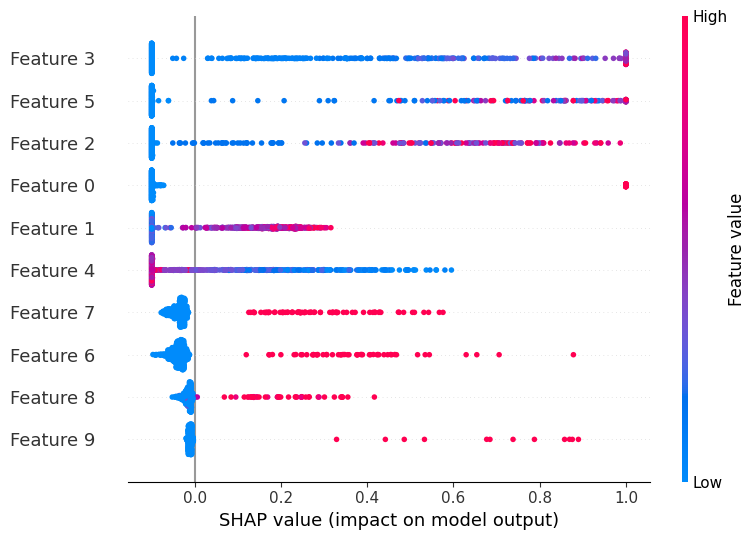

In [ ]:
shap.summary_plot(mean_shap_values[:,feature_list], X_test[:,feature_list], show=False)

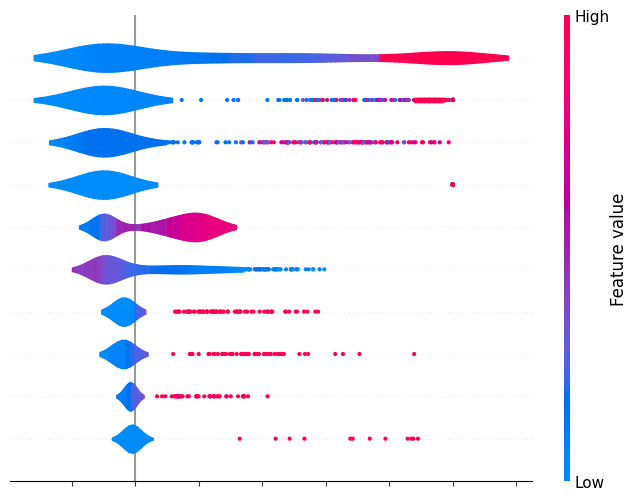

In [ ]:
shap.summary_plot(mean_shap_values[:,feature_list], X_test[:,feature_list], plot_type="violin", show=False)

In [ ]:
np.mean(mean_shap_values[:,feature_list], axis=0)

array([ 0.18267389, -0.00553597, -0.01505125,  0.07102734, -0.01201462,
        0.01293132, -0.00295565,  0.00162549,  0.00027091,  0.00317477],
      dtype=float32)

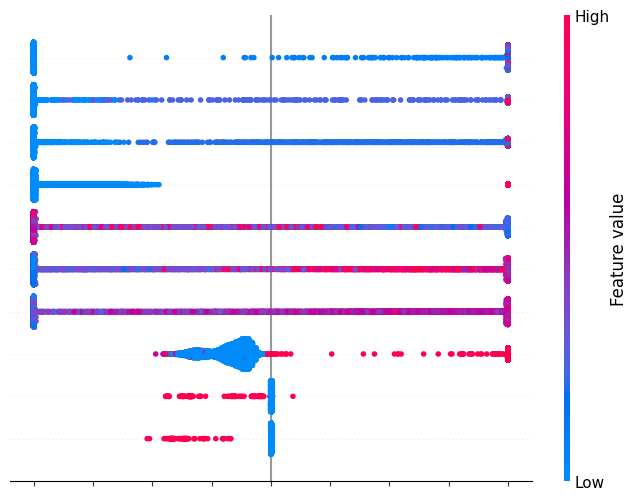

In [ ]:
shap.summary_plot(mean_shap_values[:,feature_list], X_combined[:,feature_list], show=False)
plt.gca().set_xticklabels([])
plt.gca().set_xlabel('')
plt.gca().set_yticklabels([])
plt.savefig("XGB_train_shap.png")

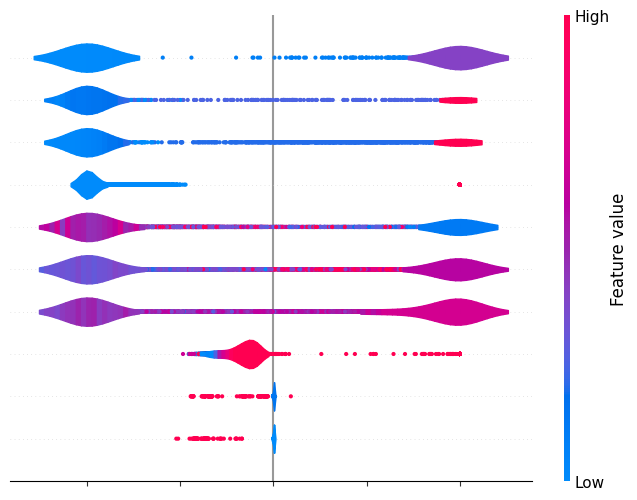

In [ ]:
shap.summary_plot(mean_shap_values[:,feature_list], X_combined[:,feature_list], plot_type="violin", show=False)
plt.gca().set_xticklabels([])
plt.gca().set_xlabel('')
plt.gca().set_yticklabels([])
plt.savefig("XGB_train_shap_violin.png")